#  <center> Speech Emotion Recognition <center>

This project aims to implement a Convolutional Neural Network (CNN) classification model that will analyze the audio form of human speech to detect and present emotions expressed through speaking.

With this Artificial Intelligence technology, a customer's sentiment throughout a conversation with a customer care representative will be evaluated. Knowing customers' sentiments in real time over various parts of the call can help understand customers' satisfaction level with the company services. Hence, service-providing companies can better facilitate their customers.

#### Datasets used in this project

* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)
* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2022-03-30 11:11:21.928995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 11:11:21.929021: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [134]:
# Paths for data.
RAVDESS = "/home/humairazafar/Documents/Muhammad_Awais/UBL/Data/RAVDESS/audio_speech_actors_01-24/"
SAVEE = "/home/humairazafar/Documents/Muhammad_Awais/UBL/Data/SAVEE/ALL/"
CREMA_D = "/home/humairazafar/Documents/Muhammad_Awais/UBL/Data/CREMAD/AudioWAV/"
TESS = "/home/humairazafar/Documents/Muhammad_Awais/UBL/Data/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"


##  <center> 1. Ravdess Dataframe <center>

### Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) 
The audio files from the RAVDESS dataset consist of 1440 audio streams created by 24 actors, where each actor voiced 60 times. Speech by these actors includes calm, happy, sad, angry, fearful, surprise, and disgust expressions.

Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 03-01-06-01-02-01-11.mp4
This means the meta data for the audio file is:

* Audio-only (03)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 11th Actor (11) - Male (as the actor ID number is odd)

Cited: "The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0

In [135]:
RAVDESS_directory = os.listdir(RAVDESS)

emotions = []
directory = []
for dir in RAVDESS_directory:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(RAVDESS + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        emotions.append(int(part[2]))
        directory.append(RAVDESS + dir + '/' + file)
        
# dataframe for emotion of files
emotions_df = pd.DataFrame(emotions, columns=['Emotions'])

# dataframe for path of files.
directory_df = pd.DataFrame(directory, columns=['Path'])
RAVDESS_df = pd.concat([emotions_df, directory_df], axis=1)

# changing integers to actual emotions.
RAVDESS_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
RAVDESS_df.head()

Emotions                                               Path
0    happy  /home/humairazafar/Documents/Muhammad_Awais/UB...
1      sad  /home/humairazafar/Documents/Muhammad_Awais/UB...
2    happy  /home/humairazafar/Documents/Muhammad_Awais/UB...
3    angry  /home/humairazafar/Documents/Muhammad_Awais/UB...
4     fear  /home/humairazafar/Documents/Muhammad_Awais/UB...

##  <center> 2. SAVEE dataset <center>
### Surrey Audio-Visual Expressed Emotion (SAVEE) 

This emotion recognition dataset was created by 4 native English male speakers of postgraduate students and researchers at the University of Surrey aged 27 to 31 years. These audio recordings from 4 male actors have 7 different emotions. It has 480 British English utterances in total. The sentences were chosen from the standard TIMIT corpus and phonetically balanced for each emotion. This notebook takes only the audio streams from the original audio-visual recording. The data set can be accessed from here. http://kahlan.eps.surrey.ac.uk/savee/

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [136]:
SAVEE_directory = os.listdir(SAVEE)

emotions = []
directory = []

for file in SAVEE_directory:
    directory.append(SAVEE + file)
    part = file.split('_')[1]
    emo = part[:-6]
    if emo=='a':
        emotions.append('angry')
    elif emo=='d':
        emotions.append('disgust')
    elif emo=='f':
        emotions.append('fear')
    elif emo=='h':
        emotions.append('happy')
    elif emo=='n':
        emotions.append('neutral')
    elif emo=='sa':
        emotions.append('sad')
    else:
        emotions.append('surprise')
        
# dataframe for emotion of files
emotions_df = pd.DataFrame(emotions, columns=['Emotions'])

# dataframe for path of files.
directory_df = pd.DataFrame(directory, columns=['Path'])
SAVEE_df = pd.concat([emotions_df, directory_df], axis=1)
SAVEE_df.head()

Emotions                                               Path
0       sad  /home/humairazafar/Documents/Muhammad_Awais/UB...
1   neutral  /home/humairazafar/Documents/Muhammad_Awais/UB...
2      fear  /home/humairazafar/Documents/Muhammad_Awais/UB...
3  surprise  /home/humairazafar/Documents/Muhammad_Awais/UB...
4     happy  /home/humairazafar/Documents/Muhammad_Awais/UB...

##  <center> 3. TESS dataset <center>

### Toronto Emotional Speech Set (TESS)
This is one of the four key data sets available for the training speech recognition model. It consists of 2800 audio files spoken by two actresses from the Toronto area (aged 26 and 64 years). Both actresses speak English as their first language, are university educated, and have musical training. Out of the total 2800 audio streams, each audio file has the phrase "Say the word _______" with the blank space filled by 200 different target words. These recordings portray each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral).

Cited: Pichora-Fuller, M. Kathleen; Dupuis, Kate, 2020, "Toronto emotional speech set (TESS)", https://doi.org/10.5683/SP2/E8H2MF, Scholars Portal Dataverse, V1


In [137]:
TESS_directory = os.listdir(TESS)

emotions = []
directory = []

for dir in TESS_directory:
    directories = os.listdir(TESS + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[-1]
        if part=='ps':
            emotions.append('surprise')
        else:
            emotions.append(part)
        directory.append(TESS + dir + '/' + file)
        
# dataframe for emotion of files
emotions_df = pd.DataFrame(emotions, columns=['Emotions'])

# dataframe for path of files.
directory_df = pd.DataFrame(directory, columns=['Path'])
TESS_df = pd.concat([emotions_df, directory_df], axis=1)
TESS_df.head()

Emotions                                               Path
0  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...
1  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...
2  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...
3  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...
4  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...

## <center>4. Crema DataFrame</center>

### Crowd-sourced Emotional Multimodal Actors Dataset

Abbreviated as CREMA-D, is an audio-visual dataset for emotion recognition. For audio analysis for speech recognition, only the audio streams from the original data set are chosen, consisting of 7,442 clips by 91 actors. These actors belong to various races and ethnicities such as African American, Asian, Caucasian, Hispanic, and Unspecified. Out of 91 actors, 48 are male, and 43 are female between 20 and 74. Actors spoke from a selection of 12 sentences with emotions from six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad). CREMA-D dataset can be accessed here. https://www.tensorflow.org/datasets/catalog/crema_d


In [138]:
CREMAD_directory = os.listdir(CREMA_D)

emotions = []
directory = []

for file in CREMAD_directory:
    # storing file paths
    directory.append(CREMA_D + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        emotions.append('sad')
    elif part[2] == 'ANG':
        emotions.append('angry')
    elif part[2] == 'DIS':
        emotions.append('disgust')
    elif part[2] == 'FEA':
        emotions.append('fear')
    elif part[2] == 'HAP':
        emotions.append('happy')
    elif part[2] == 'NEU':
        emotions.append('neutral')
    else:
        emotions.append('Unknown')
        
# dataframe for emotion of files
emotions_df = pd.DataFrame(emotions, columns=['Emotions'])

# dataframe for path of files.
directory_df = pd.DataFrame(directory, columns=['Path'])
CREMAD_df = pd.concat([emotions_df, directory_df], axis=1)
CREMAD_df.head()

Emotions                                               Path
0    angry  /home/humairazafar/Documents/Muhammad_Awais/UB...
1  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...
2    angry  /home/humairazafar/Documents/Muhammad_Awais/UB...
3      sad  /home/humairazafar/Documents/Muhammad_Awais/UB...
4  disgust  /home/humairazafar/Documents/Muhammad_Awais/UB...

# Creating Dataframe using all the 4 dataframes 

In [139]:
# creating Dataframe using all the 4 dataframes we created so far.
data_directory = pd.concat([RAVDESS_df, SAVEE_df, TESS_df, CREMAD_df], axis = 0)
data_directory.to_csv("data_directory.csv",index=False)
data_directory.head()

Emotions                                               Path
0    happy  /home/humairazafar/Documents/Muhammad_Awais/UB...
1      sad  /home/humairazafar/Documents/Muhammad_Awais/UB...
2    happy  /home/humairazafar/Documents/Muhammad_Awais/UB...
3    angry  /home/humairazafar/Documents/Muhammad_Awais/UB...
4     fear  /home/humairazafar/Documents/Muhammad_Awais/UB...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

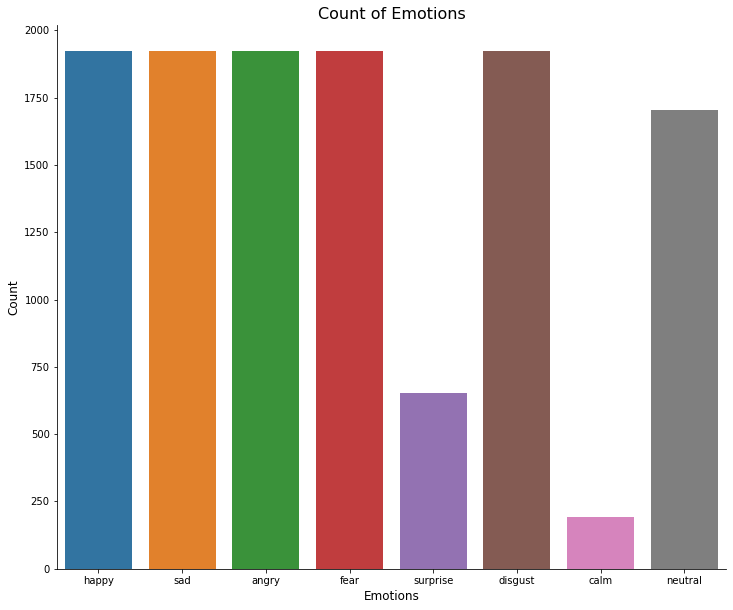

In [140]:
plt.figure(figsize=(12,10))
plt.title('Count of Emotions', size=16)
sns.countplot(data_directory.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [141]:
def create_waveplot(data, sr, emot):
    plt.figure(figsize=(12, 6))
    plt.title('Waveplot for audio with {} emotion'.format(emot), size=18)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emot):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(13, 8))
    plt.title('Spectrogram for audio with {} emotion'.format(emot), size=18)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', )   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

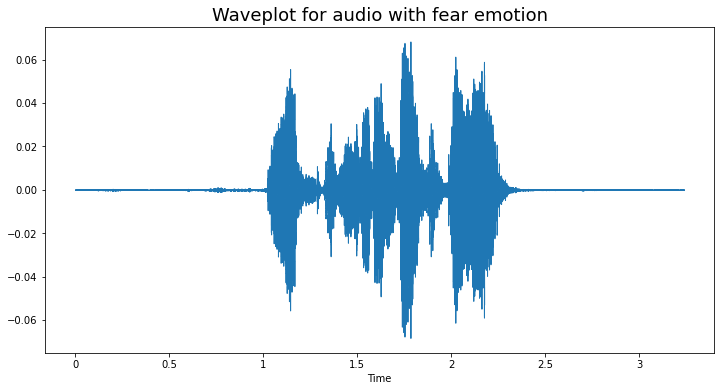

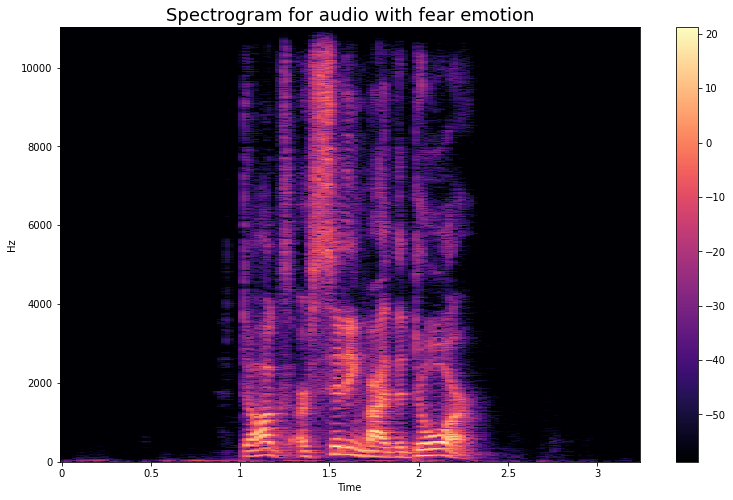

In [142]:
emotion='fear'
path = np.array(data_directory.Path[data_directory.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

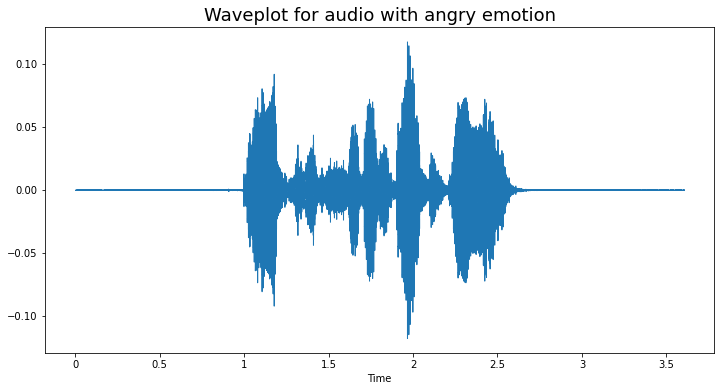

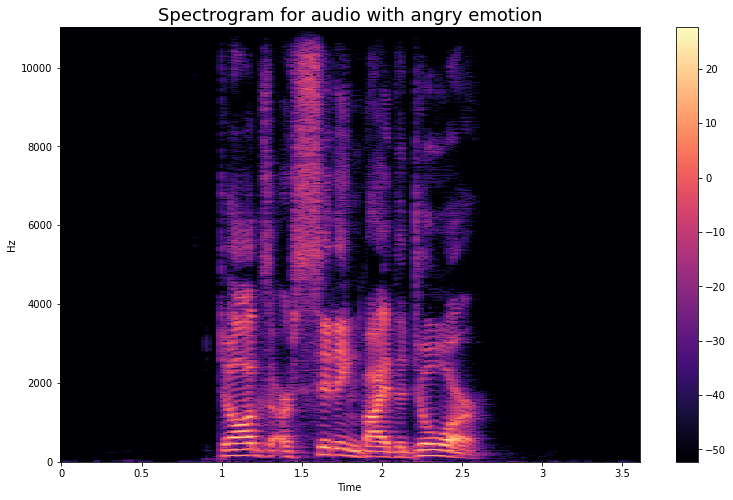

In [26]:
emotion='angry'
path = np.array(data_directory.Path[data_directory.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

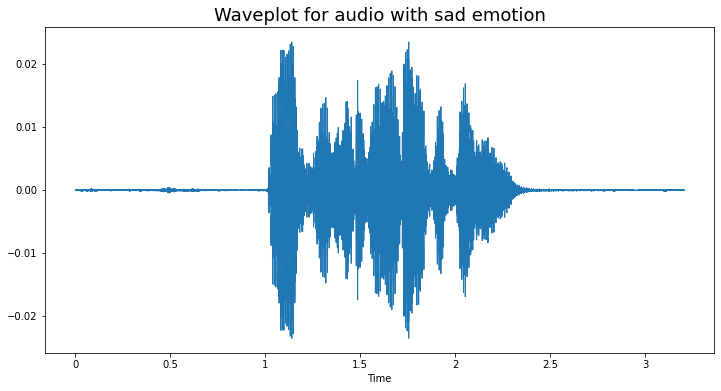

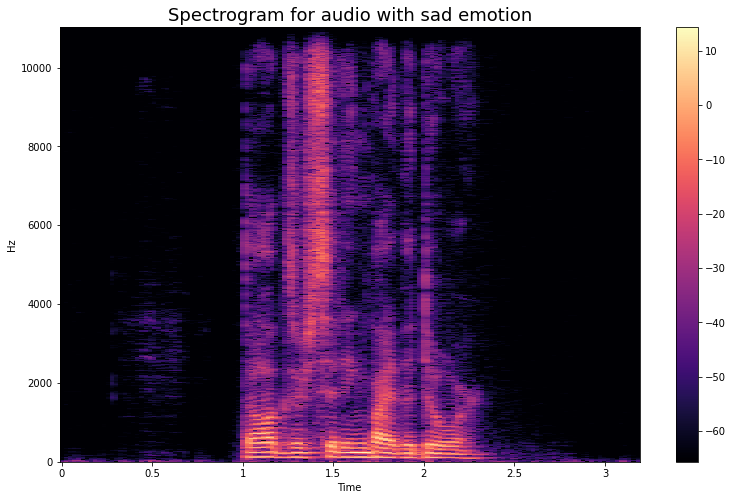

In [27]:
emotion='sad'
path = np.array(data_directory.Path[data_directory.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

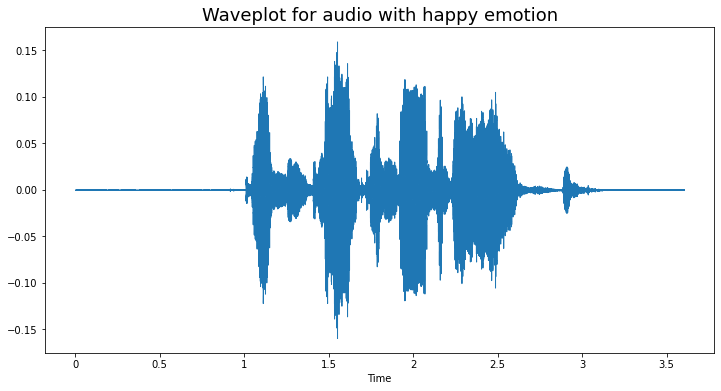

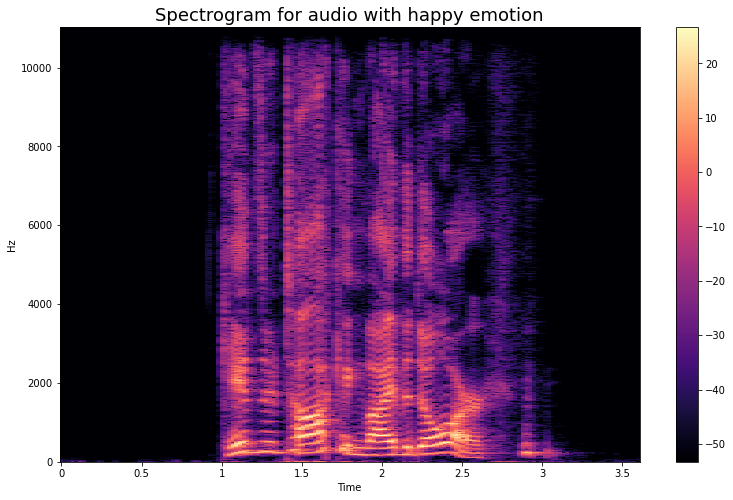

In [28]:
emotion='happy'
path = np.array(data_directory.Path[data_directory.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [29]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [30]:
def noise(data):
    noise_amplitude = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amplitude*np.random.normal(size=data.shape[0])
    return data

In [31]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [32]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

In [33]:
# taking any example and checking for techniques.
path = np.array(data_directory.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

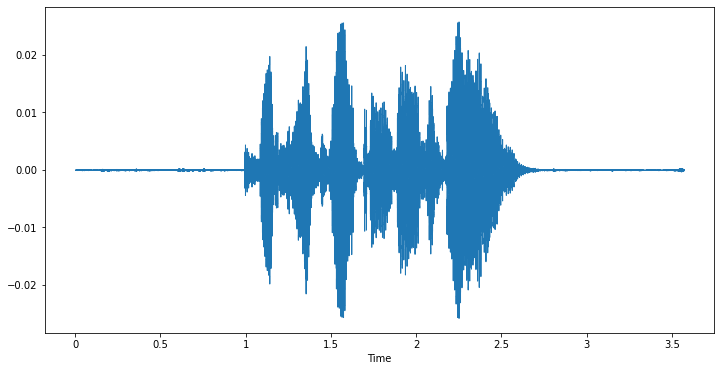

In [34]:
plt.figure(figsize=(12,6))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Pitch

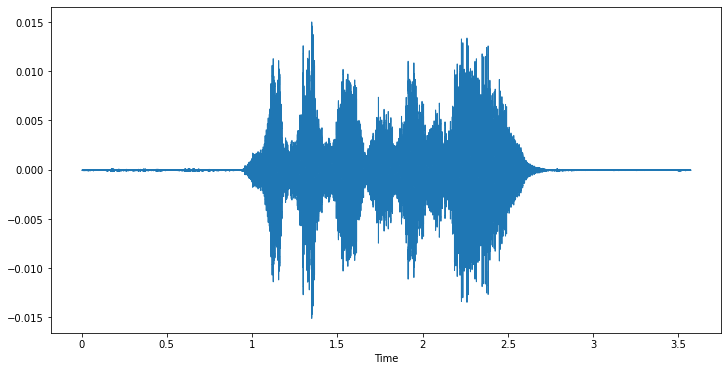

In [35]:
x = pitch(data, sample_rate)
plt.figure(figsize=(12,6))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Noise Injection

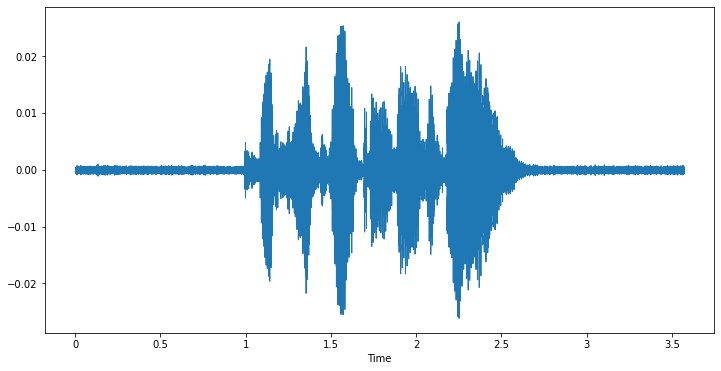

In [36]:
x = noise(data)
plt.figure(figsize=(12,6))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 4. Shifting

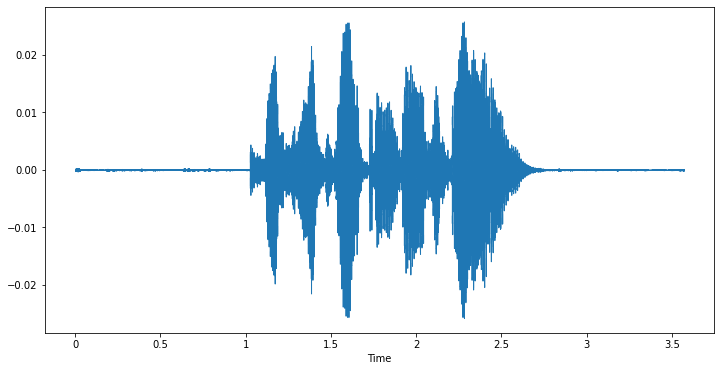

In [37]:
x = shift(data)
plt.figure(figsize=(12,6))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Stretching

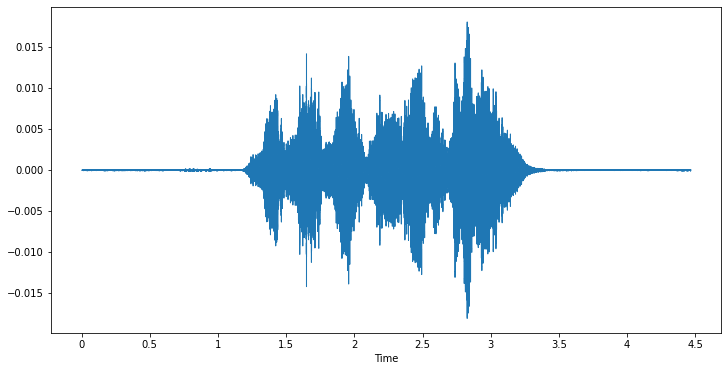

In [38]:
x = stretch(data)
plt.figure(figsize=(12,6))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project we are not going deep in feature selection process to check which features are good for our dataset rather we are only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model

In [39]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [40]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [41]:
X, Y = [], []
for path, emotion in zip(data_directory.Path, data_directory.Emotions):
    feature = get_features(path)
    for emo in feature:
        X.append(emo)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [42]:
len(X), len(Y), data_directory.Path.shape

(36483, 36483, (12161,))

In [43]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.229818  0.646757  0.656461  0.755503  0.783504  0.710632  0.625038   
1  0.286377  0.674761  0.718660  0.811398  0.836204  0.773676  0.673483   
2  0.112449  0.685578  0.639785  0.700852  0.780533  0.706428  0.642526   
3  0.176595  0.616958  0.654329  0.621573  0.643588  0.648735  0.598159   
4  0.264558  0.705284  0.741483  0.715992  0.736446  0.755088  0.681194   

          7         8         9  ...       153           154           155  \
0  0.641006  0.685694  0.698038  ...  0.000003  4.802562e-06  4.371399e-06   
1  0.662626  0.666881  0.679661  ...  0.000020  2.157599e-05  2.130387e-05   
2  0.631121  0.693670  0.697011  ...  0.000001  6.932526e-07  8.719000e-07   
3  0.637657  0.634627  0.669748  ...  0.000002  3.180307e-06  5.934643e-06   
4  0.651472  0.650824  0.691283  ...  0.000035  3.709904e-05  3.812214e-05   

        156       157       158       159           160           161  labels  
0  0.000006  0.000008  0.000007  0.000005  1.811264e-06  1.227052e-07   happy  
1  0.000024  0.000024  0.000024  0.000021  1.863722e-05  1.697241e-05   happy  
2  0.000001  0.000001  0.000001  0.000001  3.369652e-07  2.087864e-08   happy  
3  0.000009  0.000010  0.000009  0.000006  2.256563e-06  1.178393e-07     sad  
4  0.000042  0.000043  0.000042  0.000038  3.517615e-05  3.420192e-05     sad  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

In [3]:
Features = pd.read_csv('features.csv')
Features

0         1         2         3         4         5         6  \
0      0.229818  0.646757  0.656461  0.755503  0.783504  0.710632  0.625038   
1      0.288411  0.684810  0.756045  0.841891  0.805046  0.736265  0.664958   
2      0.112449  0.685578  0.639785  0.700852  0.780533  0.706428  0.642526   
3      0.176595  0.616958  0.654329  0.621573  0.643588  0.648735  0.598159   
4      0.230283  0.673929  0.713434  0.675057  0.702123  0.722109  0.653647   
...         ...       ...       ...       ...       ...       ...       ...   
36478  0.237417  0.690957  0.687168  0.669315  0.718247  0.786728  0.718038   
36479  0.136709  0.668425  0.633985  0.580650  0.592293  0.657292  0.660901   
36480  0.053618  0.647365  0.714879  0.670479  0.512763  0.567810  0.573295   
36481  0.136295  0.705906  0.773374  0.747953  0.625252  0.666630  0.630957   
36482  0.058760  0.662627  0.651659  0.657768  0.681664  0.528078  0.569062   

              7         8         9  ...           153           154  \
0      0.641006  0.685694  0.698038  ...  2.800654e-06  4.802562e-06   
1      0.671027  0.662450  0.721776  ...  2.375437e-05  2.402994e-05   
2      0.631121  0.693670  0.697011  ...  1.439238e-06  6.932526e-07   
3      0.637657  0.634627  0.669748  ...  1.819338e-06  3.180307e-06   
4      0.646298  0.640649  0.681180  ...  8.768825e-06  1.012394e-05   
...         ...       ...       ...  ...           ...           ...   
36478  0.613209  0.633504  0.693914  ...  2.019114e-03  2.076263e-03   
36479  0.548564  0.585684  0.627053  ...  2.139702e-07  1.888599e-07   
36480  0.744554  0.679781  0.589190  ...  4.963745e-07  4.620483e-07   
36481  0.750320  0.709107  0.638213  ...  4.525973e-04  4.880167e-04   
36482  0.549336  0.719798  0.648658  ...  4.403389e-07  3.975169e-07   

                155           156           157           158           159  \
0      4.371399e-06  5.839600e-06  7.974158e-06  7.146305e-06  4.991307e-06   
1      2.341323e-05  2.584218e-05  2.741905e-05  2.632957e-05  2.342522e-05   
2      8.719000e-07  1.159460e-06  1.047218e-06  1.372440e-06  1.190649e-06   
3      5.934643e-06  8.682945e-06  9.599142e-06  8.855191e-06  6.406420e-06   
4      1.207454e-05  1.493062e-05  1.576752e-05  1.558327e-05  1.248595e-05   
...             ...           ...           ...           ...           ...   
36478  1.917863e-03  1.961814e-03  2.164961e-03  2.084211e-03  2.225888e-03   
36479  1.727084e-07  1.601528e-07  1.513811e-07  1.437350e-07  1.269134e-07   
36480  4.359352e-07  4.150893e-07  3.984890e-07  3.857213e-07  3.759194e-07   
36481  4.534277e-04  4.591733e-04  4.483641e-04  4.685339e-04  4.717272e-04   
36482  3.666442e-07  3.428169e-07  3.248699e-07  3.102660e-07  2.732241e-07   

                160           161   labels  
0      1.811264e-06  1.227052e-07    happy  
1      2.112869e-05  2.000690e-05    happy  
2      3.369652e-07  2.087864e-08    happy  
3      2.256563e-06  1.178393e-07      sad  
4      8.991781e-06  6.723313e-06      sad  
...             ...           ...      ...  
36478  2.117365e-03  2.060948e-03    happy  
36479  8.418364e-08  4.330622e-08    happy  
36480  3.691826e-07  3.649388e-07  neutral  
36481  4.601999e-04  4.386417e-04  neutral  
36482  1.769352e-07  8.662430e-08  neutral  

[36483 rows x 163 columns]

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [4]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [5]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [79]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27362, 162), (27362, 8), (9121, 162), (9121, 8))

In [80]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27362, 162), (27362, 8), (9121, 162), (9121, 8))

In [81]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27362, 162, 1), (27362, 8), (9121, 162, 1), (9121, 8))

## Modelling

In [82]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))   ### added

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 21, 128)         

In [83]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 21s 48ms/step - loss: 1.7292 - accuracy: 0.2935 - val_loss: 1.5029 - val_accuracy: 0.3904 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 20s 46ms/step - loss: 1.4917 - accuracy: 0.3987 - val_loss: 1.3887 - val_accuracy: 0.4549 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 20s 47ms/step - loss: 1.3873 - accuracy: 0.4440 - val_loss: 1.3103 - val_accuracy: 0.4776 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 20s 47ms/step - loss: 1.3272 - accuracy: 0.4683 - val_loss: 1.2689 - val_accuracy: 0.4835 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 20s 48ms/step - loss: 1.2793 - accuracy: 0.4859 - val_loss: 1.1999 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 20s 47ms/step - loss: 1.2515 - accuracy: 0.5026 - val_loss: 1.2078 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 20s 

286/286 [==============================] - 2s 8ms/step - loss: 1.0443 - accuracy: 0.6197
Accuracy of SER model on test data :  61.96689009666443 %


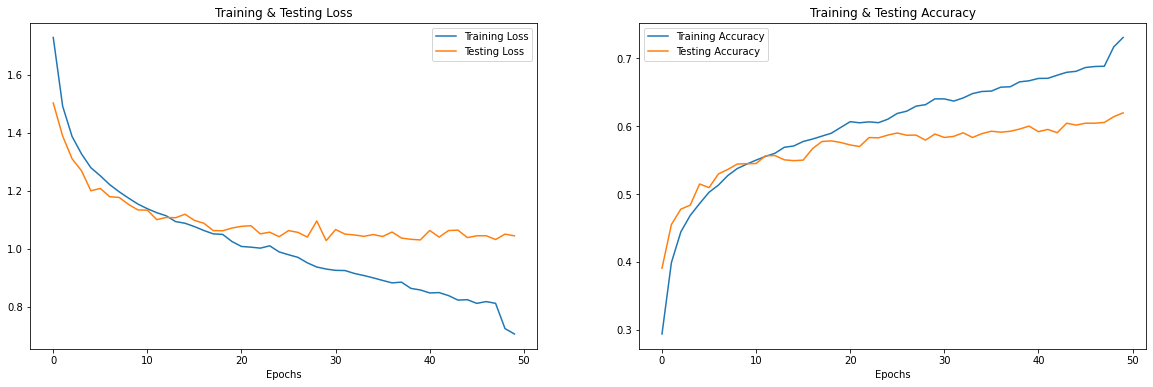

In [84]:
print("Accuracy of SER model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [85]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [86]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1              sad           sad
2            happy         happy
3          disgust       disgust
4              sad          fear
5             calm          calm
6          neutral          fear
7          neutral           sad
8            angry         angry
9            angry         happy

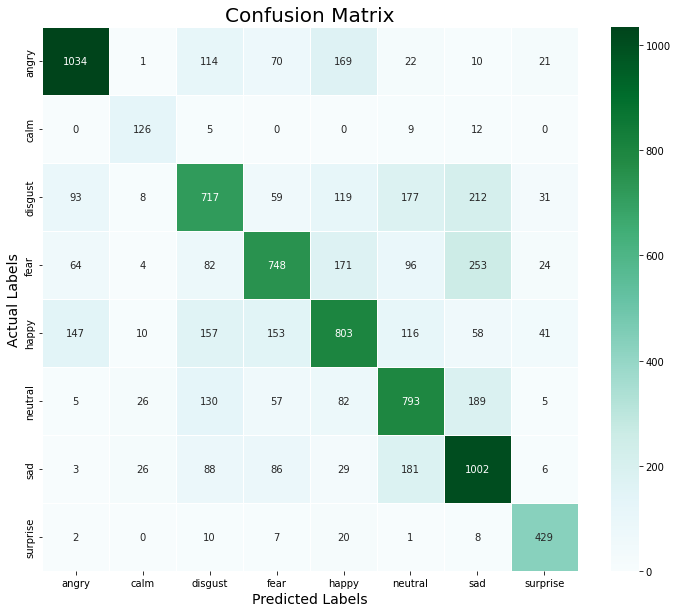

In [103]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='BuGn', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

Blacks' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.74      0.75      1441
        calm       0.73      0.85      0.78       152
     disgust       0.53      0.54      0.53      1416
        fear       0.62      0.55      0.58      1442
       happy       0.59      0.58      0.58      1485
     neutral       0.58      0.60      0.59      1287
         sad       0.62      0.67      0.64      1421
    surprise       0.87      0.89      0.88       477

    accuracy                           0.63      9121
   macro avg       0.66      0.68      0.67      9121
weighted avg       0.63      0.63      0.63      9121



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 63% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

___
____
____
____
____

# Saving the model

In [104]:
import joblib
joblib.dump(model, 'ER_model_E50_62%.joblib')

INFO:tensorflow:Assets written to: ram://3dfc2855-651f-41cf-ad10-9307bb474902/assets


['ER_model_E50_62%.joblib']

In [105]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('ESR_model_E50_62%_pkl', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://37c69c72-0522-4c42-82b6-46706297c345/assets


# Importing the saved model

In [2]:
import joblib
ERmodel_file = joblib.load('ER_model_E50_63%.joblib')

2022-03-27 01:22:03.108820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-27 01:22:03.108951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-27 01:22:03.109056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-27 01:22:03.109157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-03-27 01:22:03.109259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

# Making Prediction

In [18]:

prediction = ERmodel_file.predict(x_test)

prediction_inv = encoder.inverse_transform(prediction)


# Making dataframe from Predictions

In [19]:
pred_df = pd.DataFrame(columns=['Predicted Labels'])
pred_df['Predicted Labels'] = prediction_inv.flatten()

pred_df.head(10)

Predicted Labels
0          disgust
1              sad
2            happy
3          disgust
4              sad
5              sad
6          neutral
7              sad
8            angry
9            angry

# Our data

In [6]:
accent = pd.read_csv('features_accents.csv')
accent

0         1         2         3         4         5       6  \
0  0.165889  0.493812  0.484893  0.500209  0.459146  0.428754  0.3668   

          7         8         9  ...       153       154       155      156  \
0  0.320818  0.393264  0.443509  ...  0.064427  0.026302  0.015485  0.01138   

        157       158       159      160       161    labels  
0  0.006984  0.009524  0.010722  0.00335  0.000381  nepali13  

[1 rows x 163 columns]

In [7]:
X_accent = accent.iloc[: ,:-1].values
Y_accent = accent['labels'].values

In [8]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_accent = scaler.fit_transform(X_accent)
x_accent.shape

(1, 162)

In [9]:
# making our data compatible to model.
x_accent = np.expand_dims(x_accent, axis=2)
x_accent.shape

(1, 162, 1)

# Importing the saved model

In [15]:
import joblib
ERmodel_file = joblib.load('ER_model_E50_62%.joblib')

# Making Prediction

In [16]:

prediction = ERmodel_file.predict(x_accent)

prediction_inv = encoder.inverse_transform(prediction)


In [17]:
prediction_inv

array([['disgust']], dtype=object)

# Making dataframe from Predictions

In [18]:
pred_acc_df = pd.DataFrame(columns=['Predicted Labels'])
pred_acc_df['Predicted Labels'] = prediction_inv.flatten()

pred_acc_df.head(10)


Predicted Labels
0          disgust

In [19]:
z_accent = accent['labels']
z_accent

0    nepali13
Name: labels, dtype: object

In [20]:
pred_acc_df1 = pd.concat([pred_acc_df, z_accent], axis=1)
# pred_acc_df1.to_csv('Predictions.csv', index=False)
pred_acc_df1.head(100)

Predicted Labels    labels
0          disgust  nepali13